In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz


In [47]:
# function used for fast switching between models
def create_model(model_name: str, num_iter: int, class_weight: dict):
    d = {
        'logistic': LogisticRegression(penalty='l2',
                                       random_state=RS,
                                       max_iter=num_iter,
                                       solver='liblinear',
                                       class_weight=class_weight),
        'svm': svm.SVC(max_iter=num_iter,
                       random_state=RS,
                       gamma='scale',
                       class_weight=class_weight),
        'random-forest': RandomForestClassifier(random_state=RS,
                                                class_weight=class_weight,
                                                n_estimators=10),
        'decision-tree': tree.DecisionTreeClassifier(random_state=RS)
    }
    return d[model_name]

In [49]:
data_file_name = "./fertility_Diagnosis.csv"

data_columns = [
    'Season',
    'Age',
    'Childish diseases',
    'Accidents or serious trauma',
    'Surgical intervention',
    'High fevers in the last year',
    'Frequency of alcohol consumption',
    'Smoking habit',
    'Number of hours spent sitting per day',
    'Output'
]

In [50]:
# columns used for prediction
columns_x = [
    'Season',
    'Age',
    'Childish diseases',
    'Accidents or serious trauma',
    'Surgical intervention',
    'High fevers in the last year',
    'Frequency of alcohol consumption',
    'Smoking habit',
    'Number of hours spent sitting per day'
]

columns_x_graph = [
    #'Season',
    'Age',
    #'CD',
    'Accid',
    'Surg',
    #'Fev',
    'Alc',
    'Smok',
    'Sitt'
]

# columns that are predicted
columns_y = [
    'Output'
]

In [43]:
# random-state, used as seed value for other libraries, so that we always get the same result
RS = 1
# number of splits during cross-validation
NUM_SPLITS = 5

# class weights to fix imbalanced classes
class_weights = {
    'N': 1,
    'O': 1
}

In [51]:
# read data from csv file
df = pd.read_csv(data_file_name)

# get numpy representation of training data
X = df[columns_x].values
Y = df[columns_y].values

In [38]:
tree_model = create_model('decision-tree', 100, {})
tree_model.fit(X, Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

[Text(123.80625, 203.85, 'Age <= 0.655\ngini = 0.211\nsamples = 100\nvalue = [88, 12]\nclass = N'),
 Text(27.900000000000002, 176.67000000000002, 'Sitt <= 0.815\ngini = 0.043\nsamples = 46\nvalue = [45, 1]\nclass = N'),
 Text(13.950000000000001, 149.49, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]\nclass = N'),
 Text(41.85, 149.49, 'Sitt <= 0.94\ngini = 0.444\nsamples = 3\nvalue = [2, 1]\nclass = N'),
 Text(27.900000000000002, 122.31, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = N'),
 Text(55.800000000000004, 122.31, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = N'),
 Text(219.7125, 176.67000000000002, 'Accid <= 0.5\ngini = 0.324\nsamples = 54\nvalue = [43, 11]\nclass = N'),
 Text(146.47500000000002, 149.49, 'Sitt <= 0.345\ngini = 0.461\nsamples = 25\nvalue = [16, 9]\nclass = N'),
 Text(83.7, 122.31, 'Smok <= 0.5\ngini = 0.337\nsamples = 14\nvalue = [11, 3]\nclass = N'),
 Text(41.85, 95.13, 'Surg <= 0.5\ngini = 0.18\nsamples = 10\nvalue = [9, 1]\nclass = N'),
 Text(27.9000000000

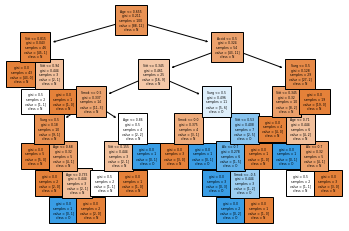

In [39]:
tree.plot_tree(decision_tree=tree_model, feature_names=columns_x_graph, class_names=['N', 'O'], filled=True, fontsize=3)

[[ 2.99988635e-01  1.99471985e-01  6.59236607e-01  1.96116884e-01
  -3.11182430e-01  9.58122221e-01  3.38100764e-01]
 [ 8.97333154e-01  9.35592172e-01  2.67416236e-01 -6.07449665e-01
  -4.55629081e-01 -2.59955860e-01 -7.54093224e-02]
 [-2.60557289e-01 -6.47304460e-01 -2.07505796e-01 -4.34476128e-01
   5.59524318e-01 -1.14146654e-01  7.14101254e-02]
 [-2.98265655e-01 -5.84613571e-01  6.84676561e-01  2.99643641e-01
  -3.10089270e-01  8.35691835e-01 -5.41819899e-02]
 [-1.38583537e-01 -5.92211830e-01  1.35725240e-01  4.89797405e-01
   6.97580490e-01  6.75951524e-02 -3.50837595e-02]
 [ 2.90145696e-01  1.42689923e-01  3.00909302e-01 -5.30400715e-01
  -3.40954765e-01 -2.36691737e-01  1.25679136e-01]
 [-5.75358555e-01 -4.14232284e-01  5.53177443e-01 -9.03222947e-01
   8.46739870e-01  8.08573713e-01 -3.33950906e-01]
 [-1.88224073e-01 -5.83953981e-01  6.80394185e-01  5.10426201e-01
  -1.66570284e-01 -1.07315695e-01 -1.71774987e-01]
 [-1.40579857e+00  1.50154338e-01  3.94042887e-02 -3.39641738e-0

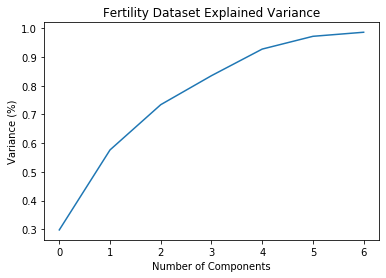

In [74]:
pca = PCA(n_components=7, random_state=RS)
# pca.fit(X)
pca.fit(X)

dataset = pca.fit_transform(X)

print(dataset)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Fertility Dataset Explained Variance')
plt.show()


In [16]:
print(pca.components_)

[[ 0.01283719  0.05232682  0.10966532 -0.0453913  -0.00538686 -0.04218245
   0.99024712 -0.02474925]
 [ 0.00990692 -0.06699909  0.22977747  0.48752428 -0.83915089 -0.02167513
  -0.00476613  0.01638965]
 [-0.0808998  -0.16431614 -0.87622998 -0.22559236 -0.36047197  0.0768976
   0.09890272  0.04636274]
 [-0.06751292  0.19211905  0.34025443 -0.81595123 -0.39441337  0.00848706
  -0.08314135  0.12015143]
 [-0.03801805 -0.95228258  0.20208867 -0.14297234  0.05238799 -0.06654862
   0.02309733  0.15074778]
 [ 0.33061166 -0.10457271 -0.02401103 -0.14357333 -0.08308571 -0.40866695
  -0.04119705 -0.82641487]
 [-0.00566259  0.10527973 -0.09321641  0.0333516   0.01685413 -0.89417375
  -0.02106751  0.42285682]]


In [17]:
print('explained variance: ', pca.explained_variance_)
print('explained variance ratio: ', pca.explained_variance_ratio_)

explained variance:  [0.66284364 0.38444265 0.24879741 0.2164958  0.10515857 0.03374631
 0.02365837]
explained variance ratio:  [0.39352227 0.22823896 0.14770802 0.12853094 0.06243138 0.02003478
 0.01404569]


In [52]:
# create cross-validation
kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RS)


In [77]:
# iterate over cross-validation sets
# train_index - indices of records used for training at current iteration over cross-validation sets
# test_index - indices of records used for testing at current iteration over cross-validation sets
classO_transformed = pca.fit_transform(df_test[columns_x].values)

for train_index, test_index in kf.split(dataset, Y):
    X_train, X_test = dataset[train_index], dataset[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    # create and train model
    model = create_model(
        'random-forest',
        300,
        class_weights
    ).fit(X_train, np.reshape(y_train, (y_train.shape[0])))

    # get model score on test set
    score = model.score(X_test, y_test)
    # get model score on whole data-set
    score_ds = model.score(dataset, Y)

    # test model on members of class 'O'
    df_test = df.loc[df.Output == 'O']
    # predictions = model.predict(df_test[columns_x].values)
    predictions = model.predict(classO_transformed)

    # print results
    print('Test score: ', score)
    print('Whole data-set score: ', score_ds)
    print(predictions)

Test score:  0.9
Whole data-set score:  0.96
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
Test score:  0.8
Whole data-set score:  0.94
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
Test score:  0.85
Whole data-set score:  0.95
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
Test score:  0.95
Whole data-set score:  0.96
['N' 'N' 'N' 'N' 'N' 'N' 'O' 'N' 'N' 'N' 'N' 'N']
Test score:  0.9
Whole data-set score:  0.96
['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
